# Tokenization: Genius Song Lyrics Subset (1%)

**Dataset:** 34'049 Songs | 26'408 Artists | 6 Genres

**Purpose:** Prepare the text data for further analysis by splitting the song lyrics into individual tokens and removing stopwords. These preprocessing steps ensure that the data is clean and structured, providing a solid foundation for subsequent analyses.

---

# 1. Preparation
## 1.1 Import Packages and Settings

In [28]:
import pandas as pd
import re
from collections import defaultdict, Counter
from itertools import tee
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
import os

In [29]:
plt.style.use('default')
%matplotlib inline
FIG_DIR = "documentation/tokenization"
os.makedirs(FIG_DIR, exist_ok=True)

## 1.2 Load Dataset

In [30]:
df = pd.read_csv('data/clean/lyrics_subset_1pct_clean.csv')

# select only english songs -> better for analysis
df = df[df["language_cld3"] == "en"]

print(f"DataFrame shape: {df.shape}")
print(f"Number of Songs: {len(df)} | Artists: {df['artist'].nunique()}")
df.head()

DataFrame shape: (34049, 11)
Number of Songs: 34049 | Artists: 26408


,title,tag,artist,year,views,features,id,language_cld3,language_ft,language,lyrics
0,2 Is Better 棍子,rap,Chris Travis,2017,4437,{},3036329,en,en,en,Bitch I'm clean Two sticks like Chow Mein Two ...
1,Scottie,rap,KrJ,2012,89,{},72180,en,en,en,My old girl left me on her old bull shit So I ...
2,Pirate Password,rock,The never land pirate band,2011,175,{},2122100,en,en,en,Avast there matey haha If a pirate asks ya for...
3,Indri,rock,Puta Volcano,2015,14,{},6889288,en,en,en,Just throw a glimpse under the shell Ghostly v...
4,Maps,misc,ANBARDA,2018,4,{},3735887,en,en,en,I miss the taste of a sweeter life I miss the ...


# 2. Tokenization
## 2.1 Build Token

First, the song lyrics are split into individual tokens, meaning that each word is extracted from the complete text. This allows for detailed analysis of word usage and frequency patterns in the lyrics. The resulting tokens are stored in the dataframe as a new column `words`, and an additional column `word_counts` is created to record the number of tokens per song.

In [31]:
def preprocess_text(text, lowercase=True):
    """Clean and tokenize text"""
    if not isinstance(text, str):
        return []
    if lowercase:
        text = text.lower()

    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    return tokens

preprocess_text("This is a test!")

['this', 'is', 'a', 'test']

In [32]:
df["words"] = df["lyrics"].apply(preprocess_text)
df["word_count"] = df["words"].apply(len) # words per song

df[['title','artist','words', 'word_count']].head()

,title,artist,words,word_count
0,2 Is Better 棍子,Chris Travis,"[bitch, im, clean, two, sticks, like, chow, me...",294
1,Scottie,KrJ,"[my, old, girl, left, me, on, her, old, bull, ...",199
2,Pirate Password,The never land pirate band,"[avast, there, matey, haha, if, a, pirate, ask...",215
3,Indri,Puta Volcano,"[just, throw, a, glimpse, under, the, shell, g...",162
4,Maps,ANBARDA,"[i, miss, the, taste, of, a, sweeter, life, i,...",428


## 2.2 Filter Stopwords
After splitting the text into tokens, stopwords are filtered and removed. This step ensures a more meaningful analysis by excluding common words that do not contribute significant semantic value to the lyrics. The resulting tokens are stored in the dataframe as a new column `tokens`, and an additional column `token_count` is created to record the number of tokens per song.

In [33]:
STOPWORDS = {
    "the","a","an","and","or","but","if","then","so","than","that","those","these","this",
    "to","of","in","on","for","with","as","at","by","from","into","over","under","up","down",
    "is","am","are","was","were","be","been","being","do","does","did","doing","have","has","had",
    "i","you","he","she","it","we","they","me","him","her","us","them","my","your","his","its","our","their",
    "not","no","yes","yeah","y'all","yall","im","i'm","i’d","i'd","i’ll","i'll","youre","you're","dont","don't",
    "cant","can't","ill","i’ll","id","i'd","ive","i’ve","ya","oh","ooh","la","na","nah"
}

def filtered_tokens(text):
    """filter stopwords"""
    tokens = preprocess_text(text)
    return [t for t in tokens if t not in STOPWORDS and not t.isdigit() and len(t) > 1]

filtered_tokens("This is a test!")

['test']

In [34]:
df["tokens"] = df["lyrics"].apply(filtered_tokens)
tokens_per_row = df["tokens"]
tokens = [t for row in tokens_per_row for t in row]
df["token_count"] = df["tokens"].apply(len)

df[['title','artist', 'words','word_count','tokens','token_count']].head()

,title,artist,words,word_count,tokens,token_count
0,2 Is Better 棍子,Chris Travis,"[bitch, im, clean, two, sticks, like, chow, me...",294,"[bitch, clean, two, sticks, like, chow, mein, ...",196
1,Scottie,KrJ,"[my, old, girl, left, me, on, her, old, bull, ...",199,"[old, girl, left, old, bull, shit, play, off, ...",108
2,Pirate Password,The never land pirate band,"[avast, there, matey, haha, if, a, pirate, ask...",215,"[avast, there, matey, haha, pirate, asks, pass...",149
3,Indri,Puta Volcano,"[just, throw, a, glimpse, under, the, shell, g...",162,"[just, throw, glimpse, shell, ghostly, voices,...",103
4,Maps,ANBARDA,"[i, miss, the, taste, of, a, sweeter, life, i,...",428,"[miss, taste, sweeter, life, miss, conversatio...",176


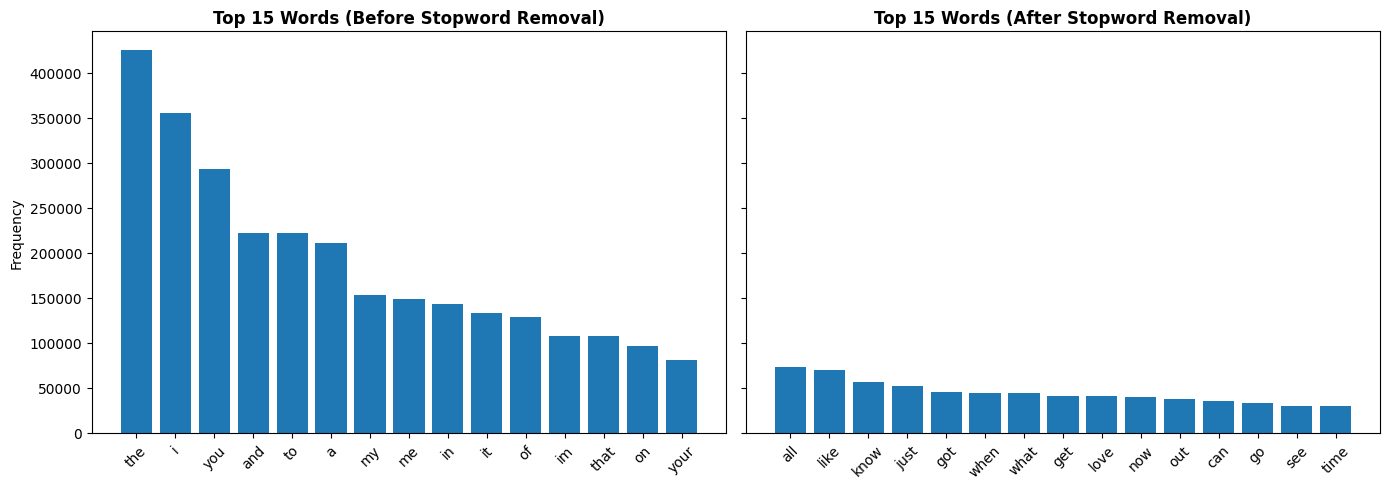

In [35]:
top_n = 15
words = [t for row in df["words"] for t in row]
tokens_filtered = [t for row in df["tokens"] for t in row]

word_counts_raw = Counter(words).most_common(top_n)
word_counts_filtered = Counter(tokens_filtered).most_common(top_n)

df_raw = pd.DataFrame(word_counts_raw, columns=["word", "count"])
df_filtered = pd.DataFrame(word_counts_filtered, columns=["word", "count"])


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].bar(df_raw["word"], df_raw["count"])
axes[0].set_title(f"Top {top_n} Words (Before Stopword Removal)", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis="x", rotation=45)

axes[1].bar(df_filtered["word"], df_filtered["count"])
axes[1].set_title(f"Top {top_n} Words (After Stopword Removal)", fontsize=12, fontweight='bold')
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "top_15_words.png"), dpi=150)
plt.show()
plt.close()


The plots above show the frequency of the 15 most common words before and after removing stopwords. We can clearly see that removing stopwords makes a significant difference: the most frequent word after filtering does not even appear among the top 15 words before stopword removal.

# 3. Save final Dataset
The final dataset with the new columns `tokens`, `token_count`, `words` and `word_count` is shown below. It serves as the cleaned and preprocessed version of the original data, ready for subsequent text analysis steps. Finally, the dataset is saved locally under `data/clean/data.csv`.

In [36]:
df.head()

,title,tag,artist,year,views,features,id,language_cld3,language_ft,language,lyrics,words,word_count,tokens,token_count
0,2 Is Better 棍子,rap,Chris Travis,2017,4437,{},3036329,en,en,en,Bitch I'm clean Two sticks like Chow Mein Two ...,"[bitch, im, clean, two, sticks, like, chow, me...",294,"[bitch, clean, two, sticks, like, chow, mein, ...",196
1,Scottie,rap,KrJ,2012,89,{},72180,en,en,en,My old girl left me on her old bull shit So I ...,"[my, old, girl, left, me, on, her, old, bull, ...",199,"[old, girl, left, old, bull, shit, play, off, ...",108
2,Pirate Password,rock,The never land pirate band,2011,175,{},2122100,en,en,en,Avast there matey haha If a pirate asks ya for...,"[avast, there, matey, haha, if, a, pirate, ask...",215,"[avast, there, matey, haha, pirate, asks, pass...",149
3,Indri,rock,Puta Volcano,2015,14,{},6889288,en,en,en,Just throw a glimpse under the shell Ghostly v...,"[just, throw, a, glimpse, under, the, shell, g...",162,"[just, throw, glimpse, shell, ghostly, voices,...",103
4,Maps,misc,ANBARDA,2018,4,{},3735887,en,en,en,I miss the taste of a sweeter life I miss the ...,"[i, miss, the, taste, of, a, sweeter, life, i,...",428,"[miss, taste, sweeter, life, miss, conversatio...",176


## 3.1 Configuration

* Define output directory and file name.
* Create directory if it doesn't exist.

In [37]:
output_dir = "data/clean"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "data.csv")

## 3.2 Save Dataset locally

In [38]:
df.to_csv(output_path, index=False)

print(f"Cleaned Subset saved to: {output_path}")

Cleaned Subset saved to: data/clean\data.csv
